In [39]:
#libs

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

### Column Descriptions:

+ age (Age of the patient in years)
+ origin (place of study) - dataset
+ sex (Male/Female)
+ cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
+ trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
+ chol (serum cholesterol in mg/dl)
+ fbs (if fasting blood sugar > 120 mg/dl)
+ restecg (resting electrocardiographic results) -- Values: [normal, stt abnormality, lv hypertrophy]
+ thalach: maximum heart rate achieved
+ exang: exercise-induced angina (True/ False)
+ oldpeak: ST depression induced by exercise relative to rest
+ slope: the slope of the peak exercise ST segment
+ ca: number of major vessels (0-3) colored by fluoroscopy
+ thal: [normal; fixed defect; reversible defect]
+ num: the predicted attribute

In [2]:
# Ignore specific warnings to keep the output clean

warnings.filterwarnings("ignore", category=RuntimeWarning, module="pandas.core.arrays.base")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/heart-disease-data/heart_disease_uci.csv")

In [4]:
# check length
print("Dataset length:", len(df))

Dataset length: 920


In [5]:
# check df
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


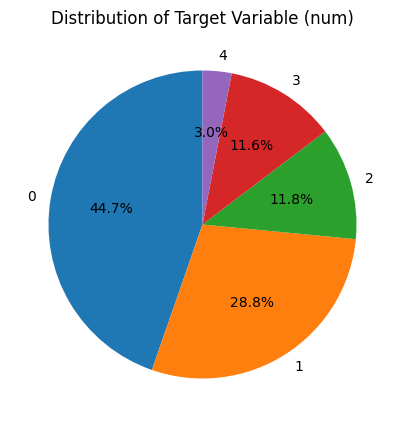

In [6]:
# Plot the distribution of the target variable 'num'

plt.figure(figsize=(8, 5))
df['num'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable (num)')
plt.ylabel('')
plt.show()

In [7]:
# Display class distribution

class_distribution = df['num'].value_counts()
print("Class distribution:\n", class_distribution)

Class distribution:
 num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


In [8]:
# Function to augment data for a specific class label

def augment_data(df, class_label, n_augmentations=3):
    df_class = df[df['num'] == class_label]
    augmented_data = []
    
    for _ in range(n_augmentations):
        df_aug = df_class.copy()
        
        # Add random noise to specific columns
        df_aug['age'] = df_aug['age'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['trestbps'] = df_aug['trestbps'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['chol'] = df_aug['chol'] + np.random.randint(-3, 4, df_aug.shape[0])
        df_aug['thalch'] = df_aug['thalch'] + np.random.randint(-3, 4, df_aug.shape[0])
        
        augmented_data.append(df_aug)
    
    return pd.concat(augmented_data)

In [9]:
# Augment data for different classes

df_class_1_augmented = augment_data(df, class_label=1, n_augmentations=3)
df_class_2_augmented = augment_data(df, class_label=2, n_augmentations=5)
df_class_3_augmented = augment_data(df, class_label=3, n_augmentations=5)
df_class_4_augmented = augment_data(df, class_label=4, n_augmentations=10)

In [10]:
# Combine the original and augmented data
df = pd.concat([df, df_class_1_augmented, df_class_2_augmented, df_class_3_augmented, df_class_4_augmented])

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

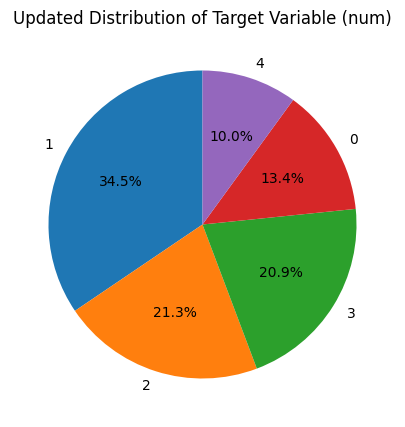

In [11]:
# Plot the updated distribution of the target variable

plt.figure(figsize=(8, 5))
df['num'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Updated Distribution of Target Variable (num)')
plt.ylabel('')
plt.show()

In [12]:
# check length
print("Dataset length:", len(df))

Dataset length: 3075


In [13]:
# check unique values
df['dataset'].unique()

array(['Cleveland', 'VA Long Beach', 'Switzerland', 'Hungary'],
      dtype=object)

In [14]:
# check nans
df.isnull().sum()

id             0
age            0
sex            0
dataset        0
cp             0
trestbps     243
chol          76
fbs          400
restecg        8
thalch       214
exang        214
oldpeak      247
slope        775
ca          2097
thal        1538
num            0
dtype: int64

In [15]:
# Data cleaning and preprocessing
df.drop(['id'], axis=1, inplace=True)

In [16]:
# Replace categorical labels with numerical ones

df['dataset'] = df['dataset'].map({
    'Cleveland': 1,
    'Hungary': 2,
    'Switzerland': 3,
    'VA Long Beach': 4
})

df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})

df['cp'] = df['cp'].map({
    'typical angina': 1,
    'atypical angina': 2,
    'non-anginal': 3,
    'asymptomatic': 4
})

df['restecg'] = df['restecg'].map({
    'normal': 0,
    'stt abnormality': 1,
    'lv hypertrophy': 2
})

df['fbs'] = df['fbs'].map({1: 1, 0: 0})
df['exang'] = df['exang'].map({1: 1, 0: 0})
df['slope'] = df['slope'].map({'downsloping': 1, 'flat': 2, 'upsloping': 3})
df['thal'] = df['thal'].map({'normal': 1, 'fixed defect': 2, 'reversible defect': 3})

In [17]:
# Fill missing values based on group means/modes

df['trestbps'] = df.groupby('num')['trestbps'].transform(lambda x: x.fillna(x.mean()))
df['chol'] = df.groupby('num')['chol'].transform(lambda x: x.fillna(x.mean()))
df['thalch'] = df.groupby('num')['thalch'].transform(lambda x: x.fillna(x.mean()))
df['oldpeak'] = df.groupby('num')['oldpeak'].transform(lambda x: x.fillna(x.mean()))
df['fbs'] = df.groupby('num')['fbs'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['restecg'] = df.groupby('num')['restecg'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['exang'] = df.groupby('num')['exang'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['slope'] = df.groupby('num')['slope'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['thal'] = df.groupby('num')['thal'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))
df['ca'] = df.groupby('num')['ca'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 0))

In [18]:
# Convert columns to integers after filling missing values

df['fbs'] = df['fbs'].astype(int)
df['restecg'] = df['restecg'].astype(int)
df['exang'] = df['exang'].astype(int)
df['slope'] = df['slope'].astype(int)
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

In [19]:
# check nans
df.isnull().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

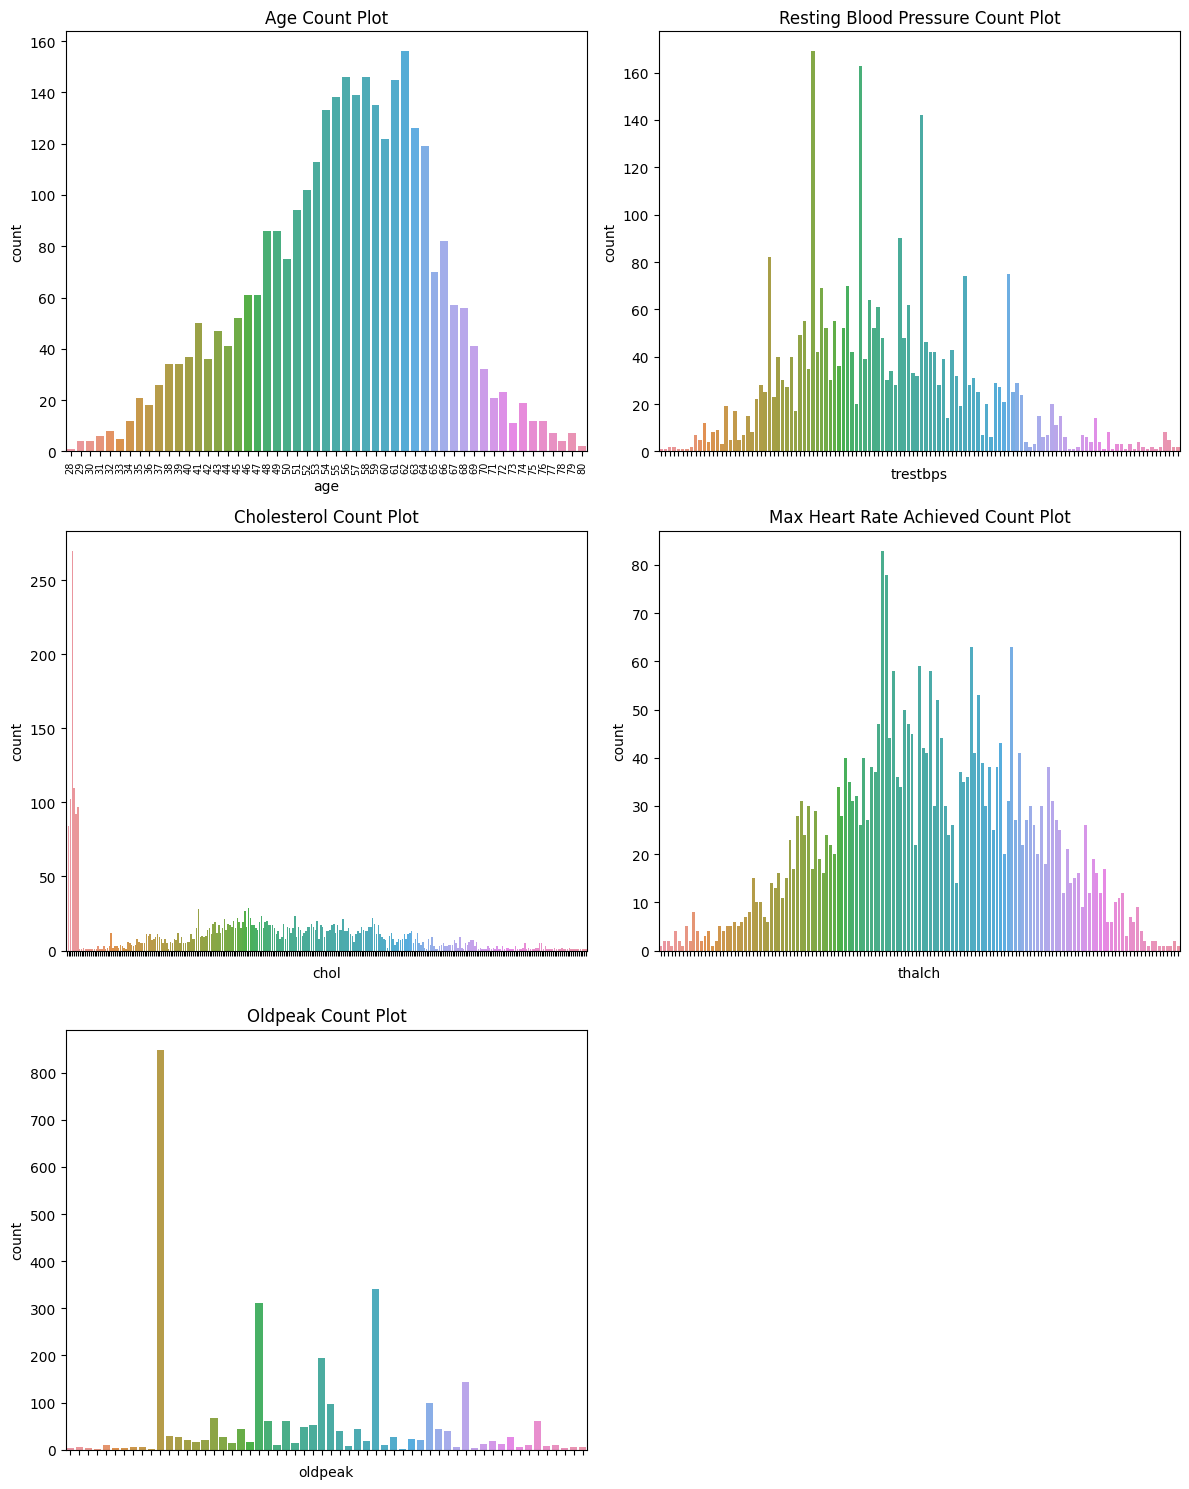

In [20]:
# Visualize feature distributions

fig, axs = plt.subplots(3, 2, figsize=(12, 15))

sns.countplot(x='age', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Age Count Plot')
axs[0, 0].tick_params(axis='x', rotation=90, labelsize=7)

sns.countplot(x='trestbps', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Resting Blood Pressure Count Plot')
axs[0, 1].set_xticklabels([])

sns.countplot(x='chol', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Cholesterol Count Plot')
axs[1, 0].set_xticklabels([])

sns.countplot(x='thalch', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Max Heart Rate Achieved Count Plot')
axs[1, 1].set_xticklabels([])

sns.countplot(x='oldpeak', data=df, ax=axs[2, 0])
axs[2, 0].set_title('Oldpeak Count Plot')
axs[2, 0].set_xticklabels([])

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [21]:
df['chol'].dropna().sort_values()

1375     -3.0
1712     -3.0
1716     -3.0
2690     -3.0
1482     -3.0
        ...  
2135    564.0
1489    601.0
207     603.0
1972    604.0
721     605.0
Name: chol, Length: 3075, dtype: float64

In [22]:
# Create bins for continuous variables for easier interpretation

df['age'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=[1, 2, 3, 4, 5])
df['trestbps'] = pd.cut(df['trestbps'], bins=[-4, 120, 130, 140, 150, 204], labels=[1, 2, 3, 4, 5])
df['chol'] = pd.cut(df['chol'], bins=[-4, 200, 240, 300, 350, 400, 500, 600, 607], labels=[1, 2, 3, 4, 5, 6, 7, 8])
df['thalch'] = pd.cut(df['thalch'], bins=[50, 100, 140, 160, 180, 220], labels=[1, 2, 3, 4, 5])
df['oldpeak'] = pd.cut(df['oldpeak'], bins=[-3, -2, 0, 2, 4, 7], labels=[1, 2, 3, 4, 5])

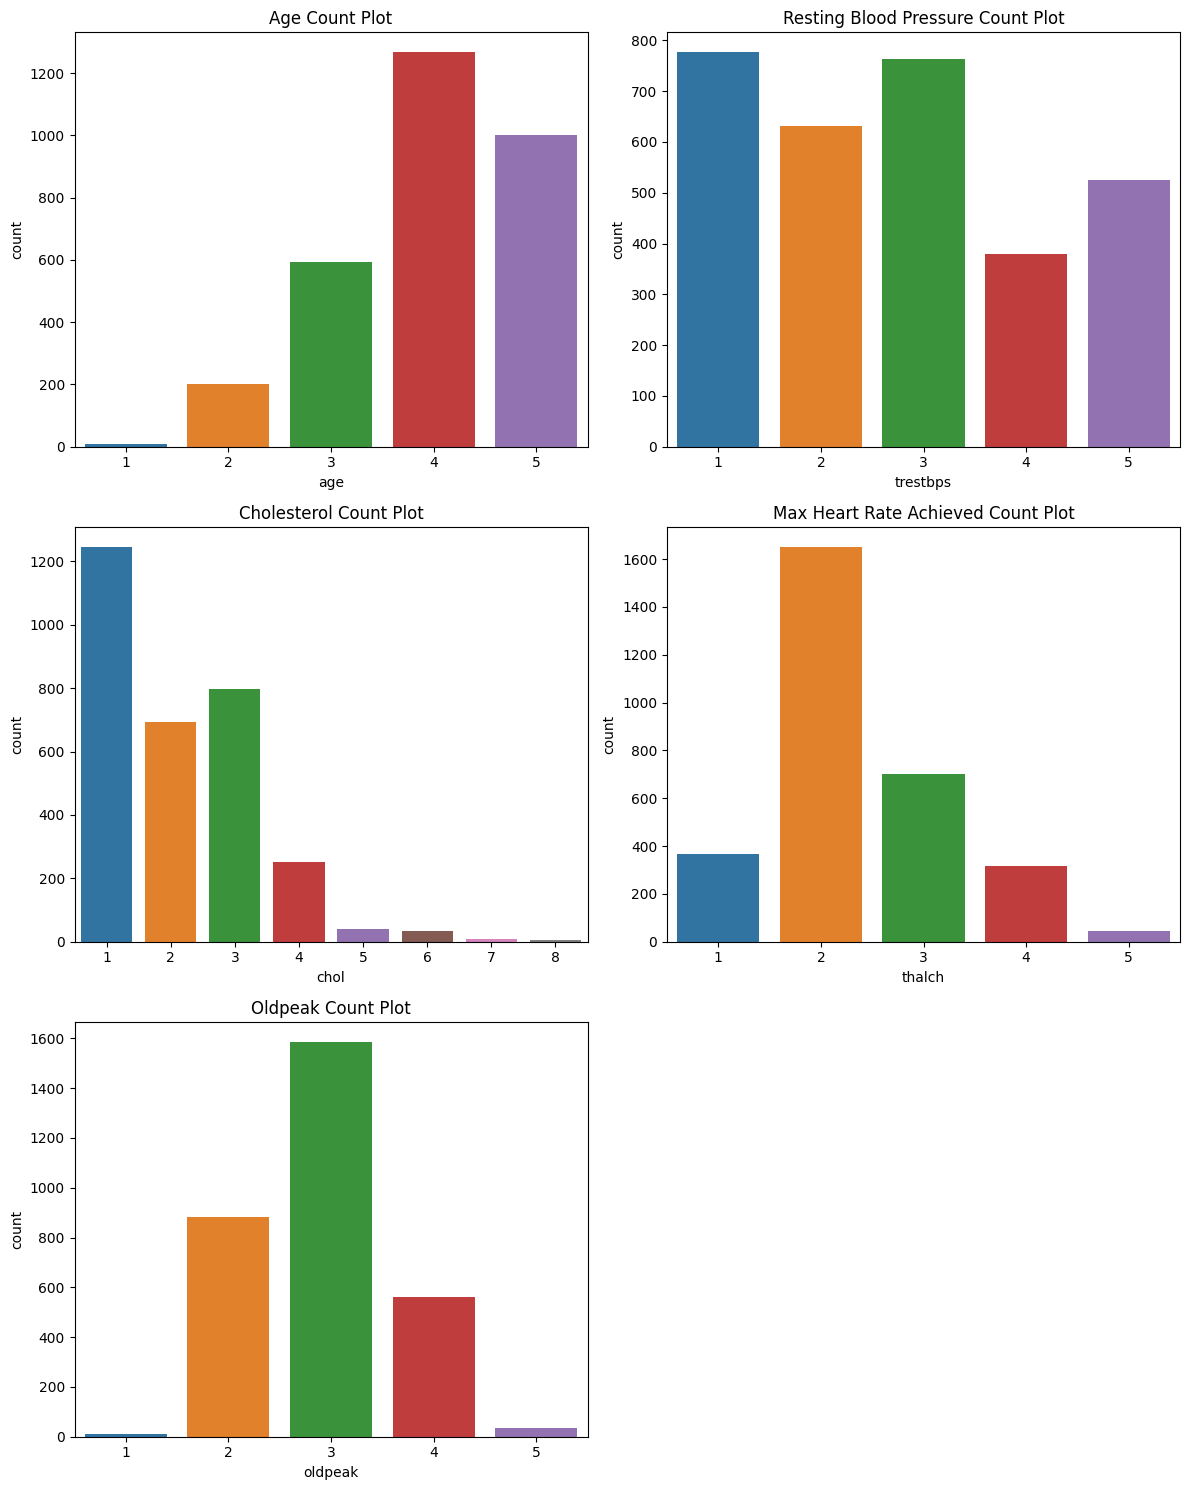

In [23]:
# Re-plot the binned features

fig, axs = plt.subplots(3, 2, figsize=(12, 15))

sns.countplot(x='age', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Age Count Plot')

sns.countplot(x='trestbps', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Resting Blood Pressure Count Plot')

sns.countplot(x='chol', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Cholesterol Count Plot')

sns.countplot(x='thalch', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Max Heart Rate Achieved Count Plot')

sns.countplot(x='oldpeak', data=df, ax=axs[2, 0])
axs[2, 0].set_title('Oldpeak Count Plot')

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [24]:
# check df
df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,5,1,1,4,3,2,0,2,2,1,4,2,2,2,4
1,4,1,4,4,3,3,0,0,2,1,3,2,1,1,2
2,4,1,4,4,5,3,1,2,3,1,3,1,3,2,4
3,4,1,1,4,1,2,1,0,4,1,3,3,2,1,2
4,4,1,3,4,2,1,1,0,2,0,2,2,2,1,3


In [25]:
# check nans
df.isnull().sum()

age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [26]:
# feature correlation matrix in dataframe

correlation_matrix = df.corr()
num_corr = correlation_matrix['num'].sort_values(ascending=False)
print(num_corr)

num         1.000000
ca          0.779348
thal        0.479134
oldpeak     0.389390
age         0.309446
cp          0.273716
restecg     0.254698
exang       0.241979
sex         0.190887
dataset     0.161965
trestbps    0.158552
fbs         0.098830
chol       -0.075322
thalch     -0.239567
slope      -0.327649
Name: num, dtype: float64


In [27]:
# Define features and target variable

X = df.drop('num', axis=1)
y = df['num']

In [28]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
# Initialize the models

gb_clf = GradientBoostingClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

In [30]:
# ensemble

stacking_clf = StackingClassifier(
    estimators=[
        ('gb', gb_clf),
        ('rf', rf_clf)
    ],
    final_estimator=LogisticRegression(solver='liblinear', max_iter=200),
    cv=5  # Cross-validation
)

In [31]:
# parameters for GS

param_grid = {
    'gb__n_estimators': [50, 100],
    'gb__learning_rate': [0.01, 0.1],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20],
    'final_estimator__C': [0.1, 1, 10]
}

In [34]:
grid_search = GridSearchCV(estimator=stacking_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=0, 
                           n_jobs=-1)

In [35]:
# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('gb',
                                                       GradientBoostingClassifier(random_state=42)),
                                                      ('rf',
                                                       RandomForestClassifier(random_state=42))],
                                          final_estimator=LogisticRegression(max_iter=200,
                                                                             solver='liblinear')),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.1, 1, 10],
                         'gb__learning_rate': [0.01, 0.1],
                         'gb__n_estimators': [50, 100],
                         'rf__max_depth': [None, 10, 20],
                         'rf__n_estimators': [50, 100]},
             scoring='accuracy')

In [36]:
# Predict and evaluate

best_stacking_clf = grid_search.best_estimator_
y_pred = best_stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Best model accuracy: {accuracy:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

Best model accuracy: 0.9821
Best parameters: {'final_estimator__C': 1, 'gb__learning_rate': 0.01, 'gb__n_estimators': 100, 'rf__max_depth': 20, 'rf__n_estimators': 100}


In [37]:
# scaling

y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
# Define the neural network model

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# compiling model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fitting
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3051 - loss: 1.6037 - val_accuracy: 0.5772 - val_loss: 1.1035
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 1.0322 - val_accuracy: 0.7333 - val_loss: 0.7816
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7382 - loss: 0.7727 - val_accuracy: 0.8016 - val_loss: 0.6332
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7959 - loss: 0.6172 - val_accuracy: 0.8309 - val_loss: 0.5455
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8126 - loss: 0.5831 - val_accuracy: 0.8423 - val_loss: 0.4889
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8341 - loss: 0.5108 - val_accuracy: 0.8585 - val_loss: 0.4445
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8395 - loss: 0.4541 - val_accuracy: 0.8634 - val_loss: 0.4129
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.4305 - val_accuracy: 0.8732 - val_loss:

In [42]:
# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

# Convert y_test back to its original format
y_test_original = y_test.argmax(axis=1)

# acc
print(classification_report(y_test_original, y_pred))
print("Accuracy:", accuracy_score(y_test_original, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        87
           1       0.96      0.97      0.97       198
           2       1.00      0.98      0.99       130
           3       0.94      1.00      0.97       132
           4       1.00      1.00      1.00        68

    accuracy                           0.97       615
   macro avg       0.97      0.96      0.97       615
weighted avg       0.97      0.97      0.97       615

Accuracy: 0.9691056910569106


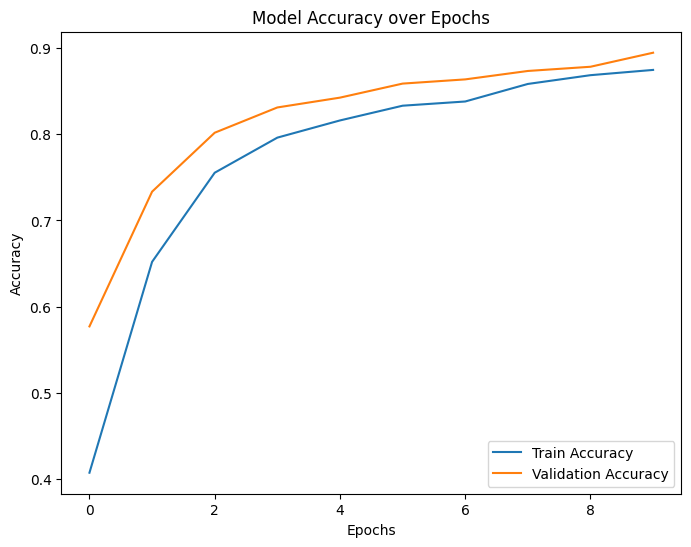

In [45]:
# Plot the training and validation accuracy over epochs

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()